# Generating and Segmenting with Character-Level Transformer

In [1]:
import sys
sys.path.append('../')
import numpy as np

## Load corpus

In [2]:
from datasets import load_dataset
dataset = load_dataset('transformersegmentation/CHILDES')
dataset

No config specified, defaulting to: childes/English
Found cached dataset childes (/Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/English/1.0.0/095e19727e2d33f7808ec4d5c95d086a19ab190ee0ae9ded0d0f7532fa5652c8)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 350664
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 19481
    })
    test: Dataset({
        features: ['text'],
        num_rows: 19481
    })
})

## Load model

In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.models.gpt2 import GPT2FeatureModel
from src.preprocessing import create_phoneme_map


tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')
phoneme_map = create_phoneme_map(tokenizer, 'English', '../data/phoible.csv')
model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-Feature-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
model.return_token_logits = True

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks/../src/preprocessing.py:29: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


In [23]:
# Generate a sample
input_ids = tokenizer.encode('h', return_tensors='pt')
sample_outputs = model.generate(input_ids, do_sample=True, max_length=50, top_k=10, top_p=0.95, num_return_sequences=3, pad_token_id=tokenizer.pad_token_id)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: h eɪ ɑː eɪ ŋ ɫ z ʃ ŋ æː oː ɾ əʊ i æː eː ŋ z m ç UTT_BOUNDARY u ɛ̃ ə y ə øː WORD_BOUNDARY ɔ̃ m ŋ ɑː eɪ ç UTT_BOUNDARY u ɛ̃ ə y ɜː x ɫ ɹ ɫ ɛː ɐ pf ŋ ɑː m
1: h UTT_BOUNDARY ŋ z m ç UTT_BOUNDARY u x øː x z m ø ʊ ɜː ŋ z m ç UTT_BOUNDARY u x øː x oʊ ʏ f ɐ ɑ̃ ɜː oʊ r f h f ʃ ŋ ɑː m ç UTT_BOUNDARY u x øː x oʊ ʏ f
2: h eɪ z m f ɫ ɡ m ɫ ɡ m ɔɪ øː ʏ WORD_BOUNDARY ts ɫ ɡ m ɫ ɡ m ɔɪ ɔ̃ eɪ z m f ɫ ɡ m æː θ øː əʊ ŋ ɫ ɡ m æː θ øː əʊ ŋ ɫ ɡ m ɫ ɡ m


## Attention Visualisation

In [24]:
import matplotlib.pyplot as plt
import seaborn

In [25]:
prompt = dataset['train']['text'][0]

def visualise_attention(prompt):
    input = tokenizer.encode(prompt, return_tensors='pt')
    prompt_text = tokenizer.convert_ids_to_tokens(input[0])
    out = model.forward(input, labels=input, output_attentions=True, output_hidden_states=True, return_dict=True)
    attentions = [att.detach().numpy() for att in out.attentions]
    
    for layer in range(1, len(attentions), 2):
        fig, axs = plt.subplots(1,8, figsize=(20, 10))
        print("Encoder Layer", layer+1)
        for h in range(8):
            seaborn.heatmap(attentions[layer][:,h][0], 
                xticklabels=prompt_text, square=True, yticklabels=prompt_text if h ==0 else [], vmin=0, vmax=1,
                cbar=False, ax=axs[h])
        plt.show()

#visualise_attention(prompt)



## Prediction Error

Plotting of prediction error from a model given a prompt.

In [26]:
def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 10))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)
        for j, start in enumerate(data.Starts):
            if start:
                ax.axvline(x=j, color='grey', alpha=0.5)
        if cutoffs:
            ax.axhline(y=cutoffs[i], color='pink', alpha=0.5)
    ax.set_xlabel('Phonemes')
    plt.show()

def print_best_result(results, score):
    best_results = results[results[score] == results[score].max()].iloc[0]
    best_result = float(best_results[score])
    best_cutoff = float(best_results['Cutoff'])
    print('Best cutoff:',best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = seaborn.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    seaborn.lineplot(results, x=measure1, y=measure2)
    plt.show()

In [27]:
from src.segmentation.segment import GPT2FeaturesSegmenter, GPT2Segmenter
segmenter = GPT2Segmenter(model, tokenizer, dataset['train']['text'][:3000])

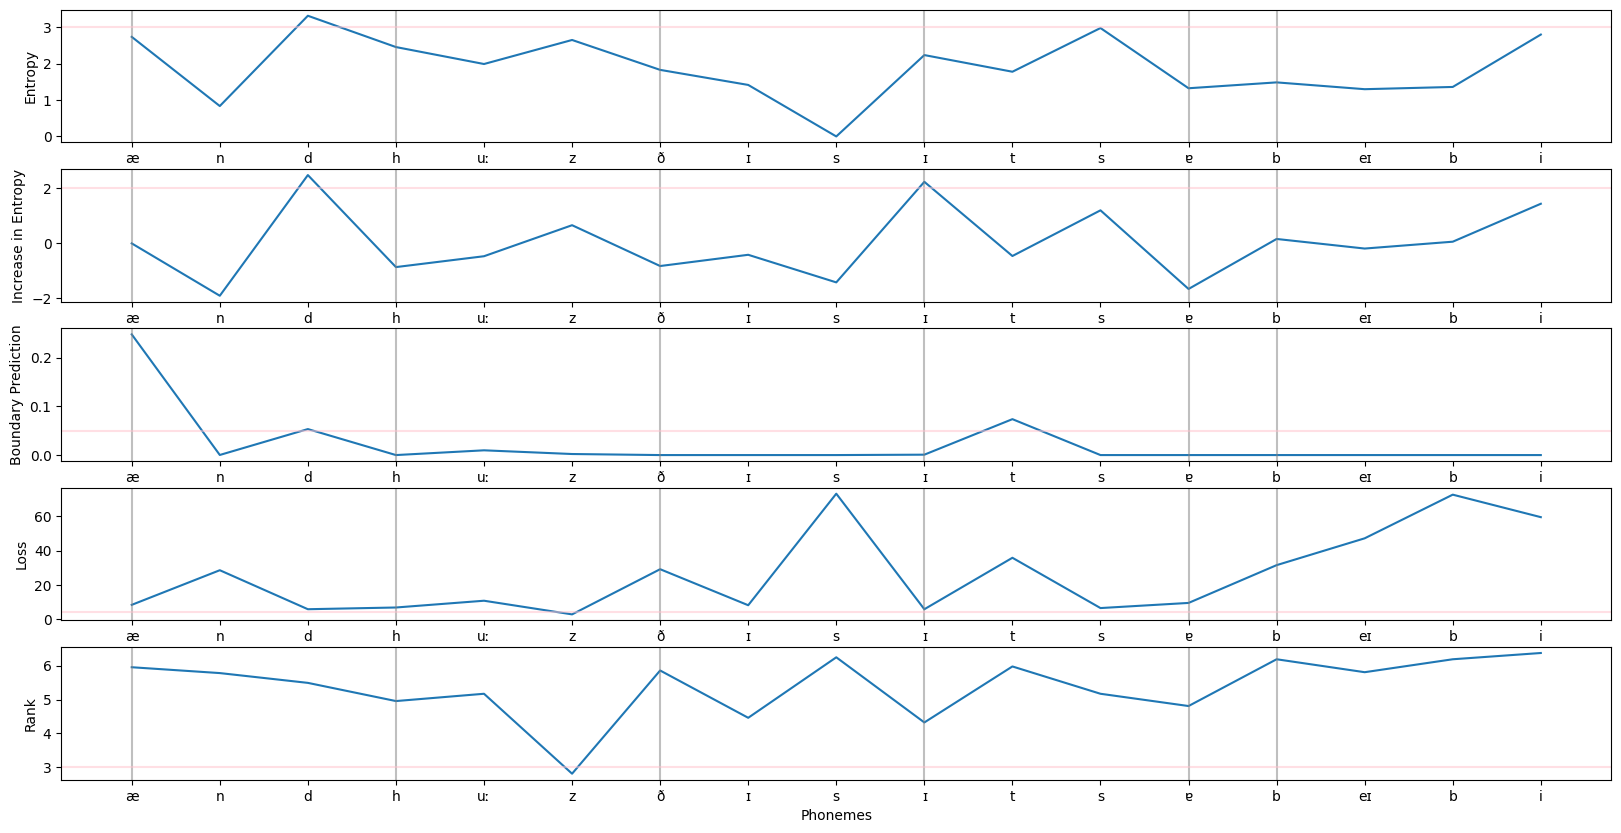

ændhuːzðɪsɪtsɐbeɪbi


In [28]:
plot_utterance(segmenter.processed_utterances[20], ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Loss', 'Rank'], [3, 2, 0.05, 4, 3])
print(''.join(list(segmenter.processed_utterances[20].Phoneme)))

In [29]:
def summarise_segmentation(measure='Entropy', score='type_fscore', cutoffs=np.linspace(0,5,51), show_plots=False):

    cutoff_data = segmenter.evaluate_cutoff_segmentation(measure, cutoffs)
    print_best_result(cutoff_data, 'type_fscore')
    if show_plots:
        plot_scores_by_cutoff(cutoff_data)
        plot_roc(cutoff_data[:-4], 'type_precision', 'type_recall')

    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))

In [30]:
for measure in ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']:
    print(measure)
    summarise_segmentation(measure)

Entropy
Best cutoff: 1.6
Best type_fscore at cutoff 1.6: 16.92
Spike type_fscore: 15.23
Increase in Entropy
Best cutoff: 0.1
Best type_fscore at cutoff 0.1: 17.29
Spike type_fscore: 15.51
Boundary Prediction
Best cutoff: 0.9
Best type_fscore at cutoff 0.9: 13.28
Spike type_fscore: 15.62
Increase in Boundary Prediction
Best cutoff: 0.0
Best type_fscore at cutoff 0.0: 17.48
Spike type_fscore: 15.6
Loss
Best cutoff: 5.0
Best type_fscore at cutoff 5.0: 9.55
Spike type_fscore: 13.04
Increase in Loss
Best cutoff: 1.5
Best type_fscore at cutoff 1.5: 13.74
Spike type_fscore: 13.75
Rank
Best cutoff: 4.7
Best type_fscore at cutoff 4.7: 13.5
Spike type_fscore: 12.21
Increase in Rank
Best cutoff: 2.9000000000000004
Best type_fscore at cutoff 2.9000000000000004: 14.34
Spike type_fscore: 13.17


Best cutoff: 1.9000000000000001
Best type_fscore at cutoff 1.9000000000000001: 34.16


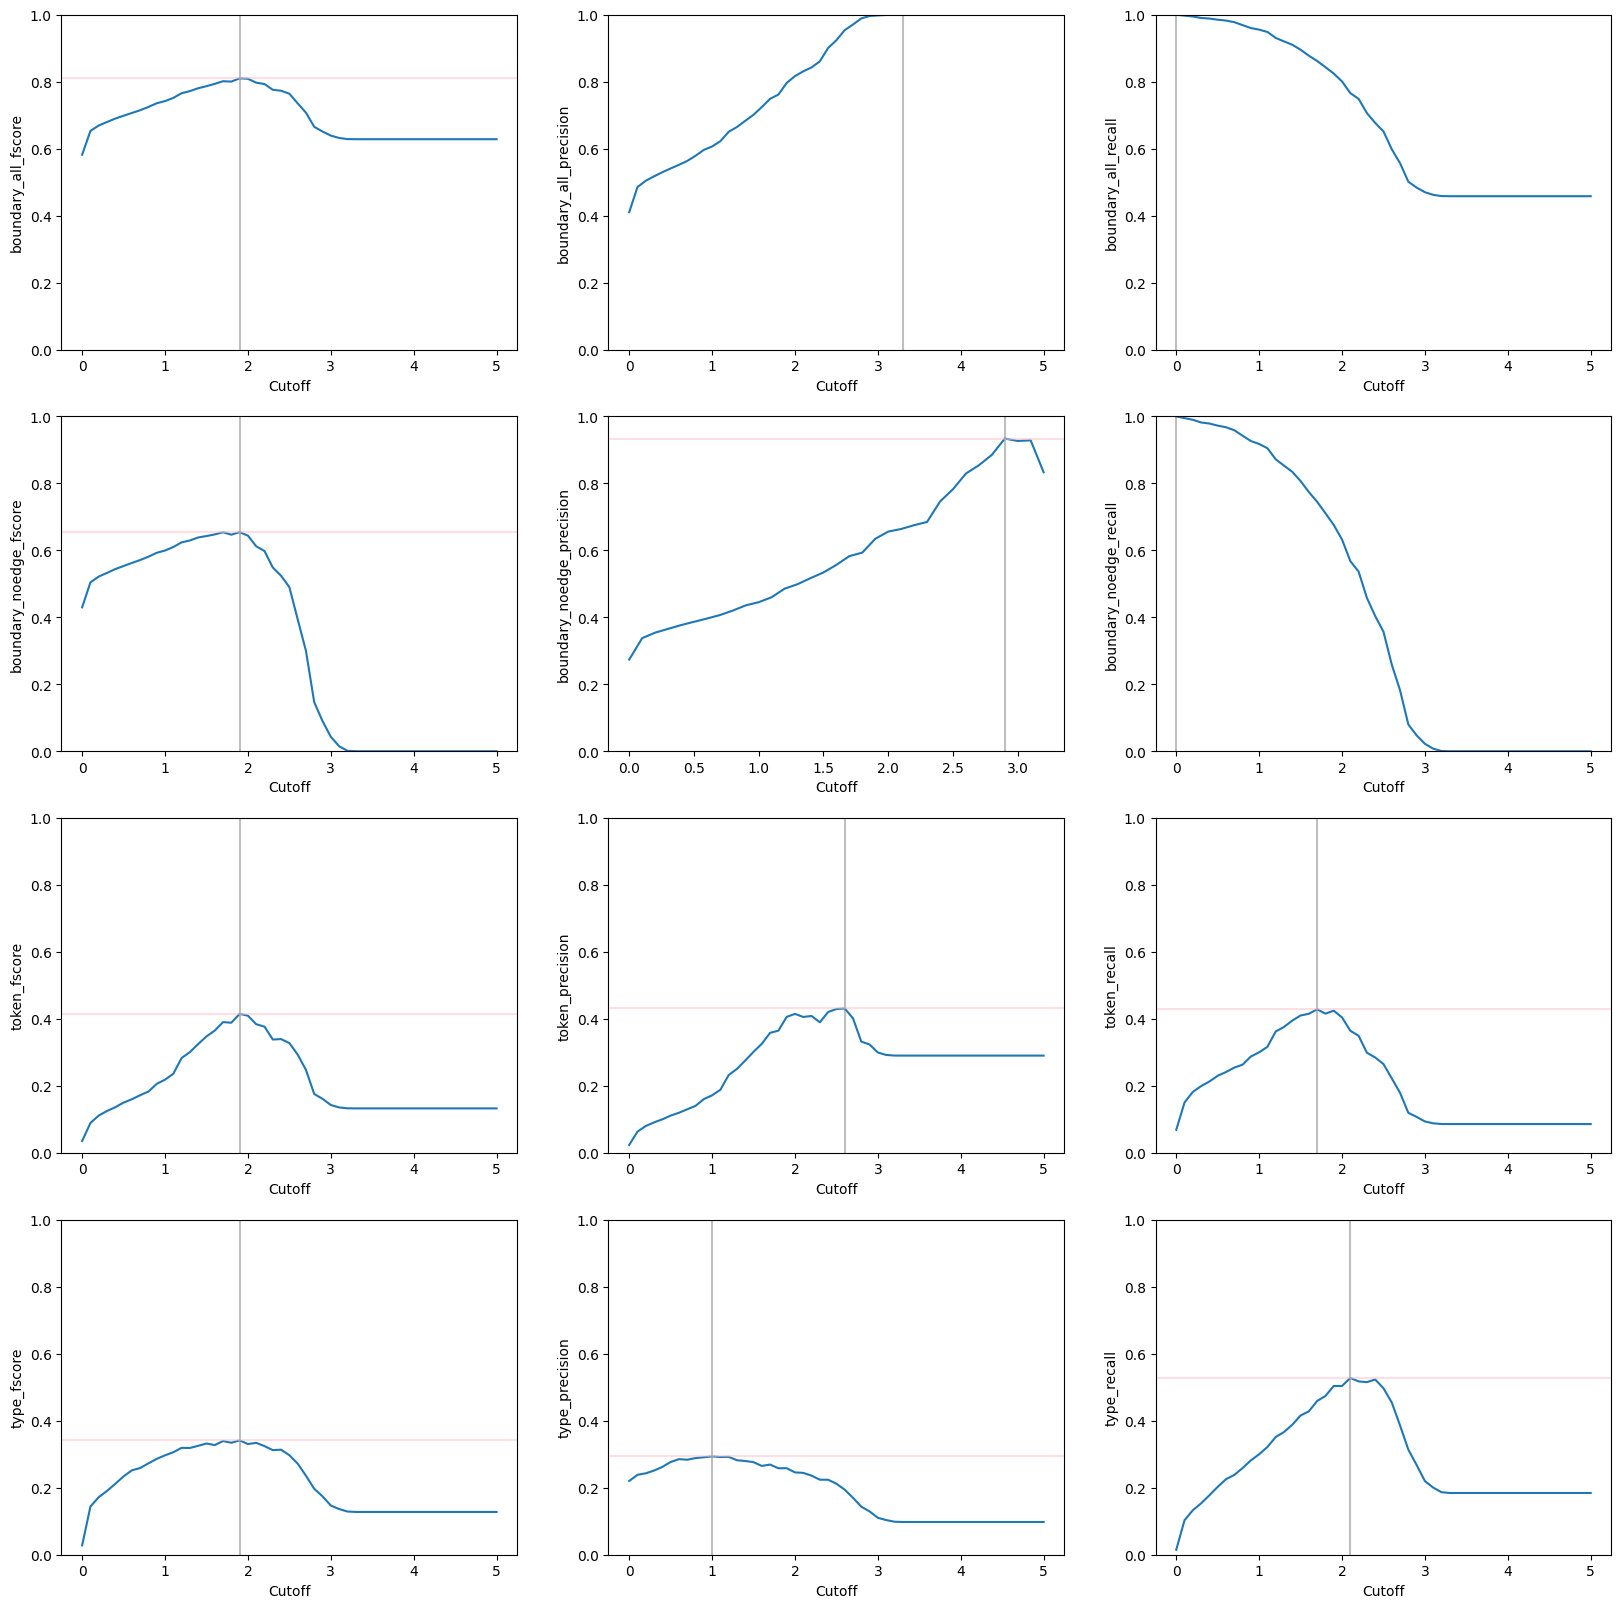

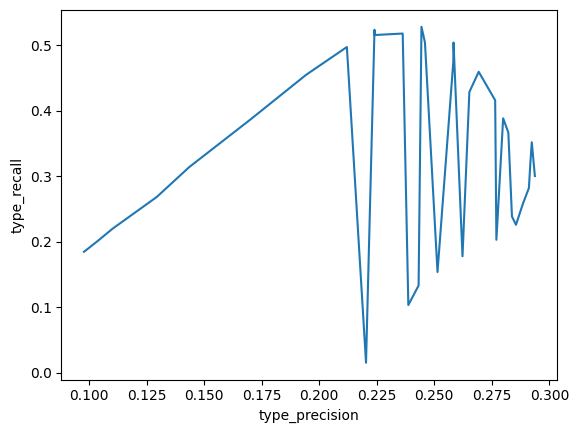

Spike type_fscore: 43.99


In [29]:
summarise_segmentation('Entropy', cutoffs=np.linspace(0,5,51), show_plots=True)